# COGS 108 - Final Project 

# Overview

I will analyze the relationship between health inspection ratings in improverished and non-white communities. To analyze this question, I will first compare the yelp ratings for a certain community to the ratings by health inspectors, keeping those data that have a significant difference then further investigating those.

I will then compare those that are left from that investigation and plot them against what we'd expect to be the least liked by yelp reviews. 

Approach I used was a "displaying data" approach, I wasn't able to do a deeper analysis because of issues I've had this past week (ER visit, protesting) so I decided to go with the simpler approach of observing patterns visually.

# Name & GitHub

- Name: Ashley Eckert
- GitHub Username: ashley41313

# Research Question

Do impoverished and racially diverse neighborhoods in North Carolina get harsher scores by health inspectors?

## Background and Prior Work

My prior background with this includes the data sets that I looked at for the project proposal. There is something fishy going on in North Carolina regarding health inspections, as reported in reference 1. Some places are exempt of the same inspections that other places have to go through. 
Also, the overall cleanliness in general in North Carolina kitches is very surprising, such that a jail kitchen in the state receives better ratings than publics restaurants. 
References (include links):
- 1)https://www.wsoctv.com/news/special-reports/9-investigates-restaurants-exempt-health-inspectio/113230492/ 
- 2)https://www.wsoctv.com/news/local/popular-area-restaurants-get-low-health-scores/769909750/

# Hypothesis


I think there will be a bias towards worse scores in communities with lower family incomes, and less Whites. 

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name: violations.csv
- Link to the dataset:in folder (given by professor)
- Number of observations:18

This dataset shows the violations and their critical nature made by inspectors. 

- Dataset Name: restaurants.csv
- Link to the dataset:in folder (given by professor)
- Number of observations: 15

This dataset ID's restaurants and their zip code as well as other info to characterize a restaurant.

- Dataset Name: inspections.csv
- Link to the dataset:in folder (given by professor)
- Number of observations: 10+

This dataset gives information to actual point deductions in the inspections for restaurants. 

- Dataset Name: yelp.csv
- Link to the dataset:in folder (given by professor)
- Number of observations:10+

Gives us a list of reviews left for restaurants. 

- Dataset Name: zipcode.csv
- Link to the dataset:in folder (given by professor) 
- Number of observations:10+

Gives important income information as well as demographics for zip codes.

I will integrate these together by first comparing the yelp reviews average in certain zip codes to the inspector rating to see if they line up with what we'd expect - high yelp ratings == high inspector ratings. We will then compare the correlations between the type of food.



# Setup

In [232]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

I cleaned the data by first removing all NA entries from the inspections csv.  
For the yelp reviews I only kept the columns with the ratings, zip code, price and type of food served. To see if there were any racial bias in the foods, those are the only variables I will need.
I also cleaned up the columns with the types of foods and instead kept one column that had the type of food it had. 

In [233]:
df = pd.read_csv('yelp.csv')
df = df.drop(columns = ['id', 'name', 'address1','latitude','longitude', 'phone'])
df.head()

,is_closed,rating,review_count,zip_code,price,hotdogs,sandwiches,pizza,tradamerican,burgers,...,italian,newamerican,chicken_wings,delis,bars,salad,seafood,bbq,bakeries,sushi
0,False,2.5,23,27560,$$,False,False,False,False,False,...,False,True,False,False,False,False,True,False,False,False
1,False,4.0,17,27519,$,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,5.0,2,27612,$,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,3.0,16,27893,$$,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,False,3.5,3,27896,$,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [1]:
def standardize_yelp(row):
    
    if row['hotdogs'] == True:
        output = 'american'
    elif row['sandwiches'] == True:
        output = 'american'
    elif row['pizza'] == True:
        output = 'american'
    elif row['tradamerican'] == True:
        output = 'american'
    elif row['burgers'] == True:
        output = 'american'
    elif row['mexican'] == True:
        output = 'mexican'
    elif row['grocery'] == True:
        output = 'grocery'
    elif row['breakfast_brunch'] == True:
        output = 'breakfast'
    elif row['coffee'] == True:
        output = 'coffee'
    elif row['chinese'] == True:
        output = 'asian'        
    elif row['italian'] == True:
        output = 'italian'       
    elif row['newamerican'] == True:
        output = 'american'        
    elif row['chicken_wings'] == True:
        output = 'wings'         
    elif row['delis'] == True:
        output = 'healthy'        
    elif row['bars'] == True:
        output = 'bars'           
    elif row['salad'] == True:
        output = 'healthy'        
    elif row['seafood'] == True:
        output = 'seafood'         
    elif row['sushi'] == True:
        output = 'asian'        
    elif row['bbq'] == True:
        output = 'bbq'            
    elif row['bakeries'] == True:
        output = 'desserts'           
    else:
        output = 'NA'
        
    return output

In [235]:
df['food_type'] = df.apply(standardize_yelp, axis=1)
cl = ['hotdogs','sandwiches','pizza','tradamerican','burgers','mexican','grocery','breakfast_brunch','coffee','chinese','italian','newamerican','chicken_wings','delis','bars','salad','seafood','bbq','bakeries','sushi']
df = df.drop(columns=cl)
df.head()

,is_closed,rating,review_count,zip_code,price,food_type
0,False,2.5,23,27560,$$,breakfast
1,False,4.0,17,27519,$,grocery
2,False,5.0,2,27612,$,italian
3,False,3.0,16,27893,$$,italian
4,False,3.5,3,27896,$,american


Next, I kept only zip codes of restaurants that are included in the other dataframes so that only data that is global will be used. 

In [236]:
#27501 < 27703
# Get names of indexes for which column Age has value 30
indexNames = df[ df['zip_code'] > 27703].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
df.sort_values(by="zip_code")

,is_closed,rating,review_count,zip_code,price,food_type
2213,False,1.0,1,15035,NaN,american
3493,False,4.0,77,22701,$$$,american
49,False,4.0,33,27023,$$,italian
47,False,3.5,4,27023,$,NA
33,False,4.5,20,27041,$,breakfast
...,...,...,...,...,...,...
1776,False,5.0,5,27703,$$,NA
1775,False,4.0,4,27703,$,american
1242,False,3.5,15,27703,$,american
1243,False,2.0,13,27703,$,american


In [237]:
#27501 < 27703
# Get names of indexes for which column Age has value 30
indexNames = df[ df['zip_code'] < 27501].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)
df.sort_values(by="zip_code")

,is_closed,rating,review_count,zip_code,price,food_type
1849,False,4.0,4,27501,$,asian
1843,False,4.0,1,27501,$$,american
1844,False,5.0,33,27501,$,grocery
1848,False,2.0,2,27501,$,american
1847,False,4.0,27,27501,$,american
...,...,...,...,...,...,...
3256,False,5.0,1,27703,NaN,NA
3644,False,4.0,20,27703,$$,NA
3593,False,3.0,10,27703,$,NA
1243,False,2.0,13,27703,$,american


I'm now cleaning up the zipcodes.csv. I kept household income over family income, since that is more inclusive of everyone in that housing unit. I also kept percentage below poverty line. I dropped the benefits, because I'm focusing on inspections, so the income and below/poverty line are enough. I also kept percent_nonwhite, so that later I can compare the whiteness of a community to it's ratings. 

In [238]:
df_zipcodes = pd.read_csv('zipcodes.csv')
df_zipcodes = df_zipcodes.drop(columns=['median_family_income_dollars', 'per_capita_income_dollars','percent_snap_benefits','percent_supplemental_security_income'])
df_zipcodes.columns = ['zip', 'income', 'percent_below_poverty_line', 'percent_nonwhite']
df_zipcodes.head()

,zip,income,percent_below_poverty_line,percent_nonwhite
0,27501,51121,10.5,17.9
1,27502,95857,3.4,18.9
2,27511,67392,9.6,24.8
3,27513,87262,3.8,27.8
4,27518,98247,5.5,19.9


In [239]:
df_violations = pd.read_csv('violations.csv')
df_violations = df_violations.drop(columns = ['hsisid','inspectdate', 'statecode','questionno','violationcode','shortdesc', 'inspectedby', 'comments','pointvalue','observationtype','violationtype','count','cdcriskfactor','cdcdataitem'])
df_violations.head()

,X.objectid,category,critical,severity
0,2149,Chemical,Yes,Priority Foundation
1,2150,Chemical,Yes,Priority Foundation
2,2151,Chemical,Yes,Priority Foundation
3,2152,Chemical,Yes,Priority Foundation
4,2153,Chemical,Yes,Priority Foundation


Now I will add the zipcode of each violation based on the X.objectid that is used here and in the restaurants dataframe.

In [240]:
df_rest = pd.read_csv('restaurants.csv')
df_rest[['X.objectid', 'postalcode']]

,X.objectid,postalcode
0,1001,27616-1895
1,1002,27502
2,1003,27587
3,1004,27601
4,1005,27597
...,...,...
3319,2996,27529
3320,2997,27603
3321,2998,27587
3322,2999,27560


Now I will clean up the zip codes and trim anything after '-'

In [241]:
def standardize_zip(zipcode):
    x = zipcode.split('-')
    return int(x[0])


In [242]:
df_rest['zip'] = df_rest['postalcode'].apply(standardize_zip)
df_ids = df_rest[['X.objectid','zip']]
df_ids.head()

,X.objectid,zip
0,1001,27616
1,1002,27502
2,1003,27587
3,1004,27601
4,1005,27597


Now I will finally clean up the inspections.csv, the final piece of data I will be using. 

In [243]:
df_inspections = pd.read_csv('inspections.csv')
df_inspections = df_inspections[['postalcode', 'num_non_critical', 'critical']]
df_inspections.head()

,postalcode,num_non_critical,critical
0,27610,7,1
1,27610,11,0
2,27610,8,1
3,27513,3,1
4,27597,4,1


Now, we'll recap the 4 dataframes we have cleaned up. 

In [244]:
df.columns = ['is_closed', 'rating', 'review_count', 'zip', 'price', 'food_type']
df

,is_closed,rating,review_count,zip,price,food_type
0,False,2.5,23,27560,$$,breakfast
1,False,4.0,17,27519,$,grocery
2,False,5.0,2,27612,$,italian
22,False,5.0,3,27517,NaN,NA
27,False,4.0,24,27601,$$,NA
...,...,...,...,...,...,...
3683,False,3.5,23,27607,19198344000,NA
3684,False,3.5,24,27607,19198213111,NA
3685,False,4.0,12,27701,19194250800,NA
3686,False,3.5,4,27526,19195526154,NA


In [245]:
df_zipcodes

,zip,income,percent_below_poverty_line,percent_nonwhite
0,27501,51121,10.5,17.9
1,27502,95857,3.4,18.9
2,27511,67392,9.6,24.8
3,27513,87262,3.8,27.8
4,27518,98247,5.5,19.9
5,27519,121815,3.2,35.2
6,27520,58455,5.0,23.5
7,27522,59221,6.0,31.4
8,27523,68342,3.1,22.4
9,27526,66025,8.4,22.5


Now I'm just cleaning up the zip codes in the other tables.

In [247]:
df_inspections['zip'] = df_inspections['postalcode'].apply(standardize_zip)
df_inspections = df_inspections.drop(columns = ['postalcode'])
df_inspections = df_inspections.sort_values(by="zip")
df_inspections

,num_non_critical,critical,zip
7918,4,1,27501
18005,0,1,27501
15588,3,1,27501
11103,6,1,27501
13823,7,1,27501
...,...,...,...
12961,2,0,28145
17259,5,1,28145
14400,1,1,28145
16302,3,0,28587


In [248]:
#27501 < 27703
# Get names of indexes for which column Age has value 30
indexNames = df_inspections[ df_inspections['zip'] > 27703].index
 
# Delete these row indexes from dataFrame
df_i = df_inspections.drop(indexNames , inplace=True)
df_inspections

,num_non_critical,critical,zip
7918,4,1,27501
18005,0,1,27501
15588,3,1,27501
11103,6,1,27501
13823,7,1,27501
...,...,...,...
9986,4,0,27695
9983,1,1,27695
12039,0,1,27695
16636,1,1,27695


# Data Analysis & Results

Now I will begin by showing a pie chart of the poverty of the sections of places in North Carolina so we can see what type of population we're dealing with.
I'm removing the outliers for the yelp reviews, those that have 1 review or are not in the zip codes we're looking for. 

The variables that the analysis takes in are zip codes, which is the main variable I will use to visualize data.
The next variable is income - which I will graph based on location.
Next variable is rating- which I will use to compare the likeliness of a place having a high rating and getting a good inspection score.

In [249]:
df_mean = df.groupby("zip").mean()
df_mean = df_mean.sort_values(by='zip')
df_mean

,is_closed,rating,review_count
zip,,,
27501,0.0,4.055556,25.888889
27502,0.0,3.610526,32.726316
27504,0.0,4.000000,4.500000
27508,0.0,2.500000,7.000000
27510,0.0,3.718750,119.875000
...,...,...,...
27650,0.0,4.500000,14.000000
27658,0.0,5.000000,30.000000
27695,0.0,5.000000,7.500000


Here I am plotting a line plot of the average rating a zip code gets. 

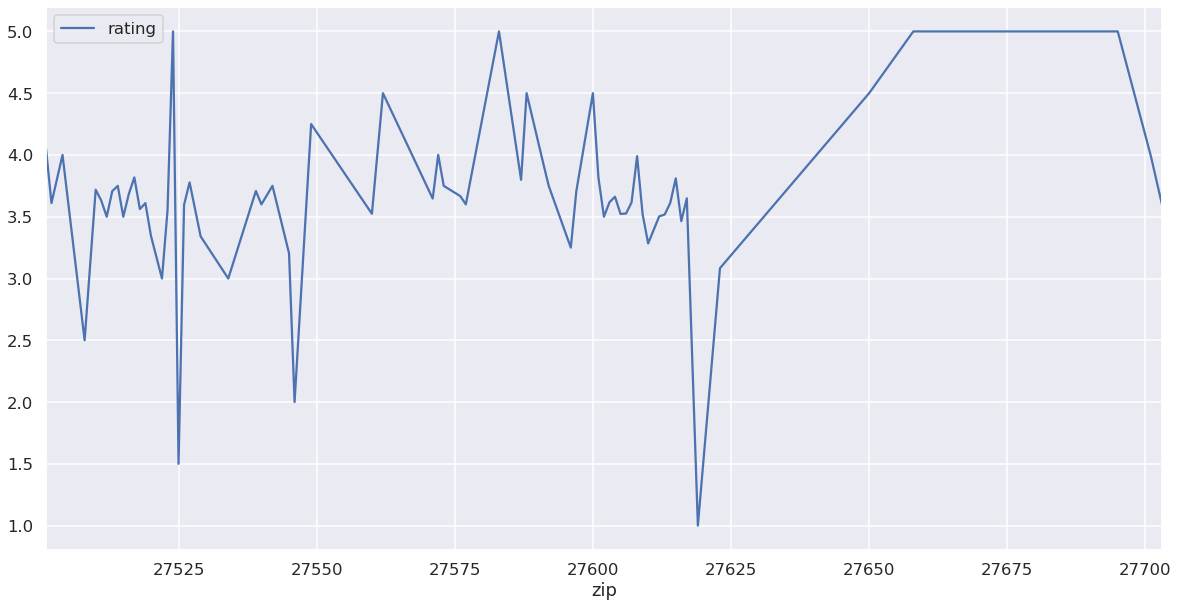

In [251]:
df_mean.plot(y='rating',grid=True, figsize=(20,10))

Now I will graph the same thing, but instead with the income of those zip codes. So we can see if there's a pattern between income and ratings. 

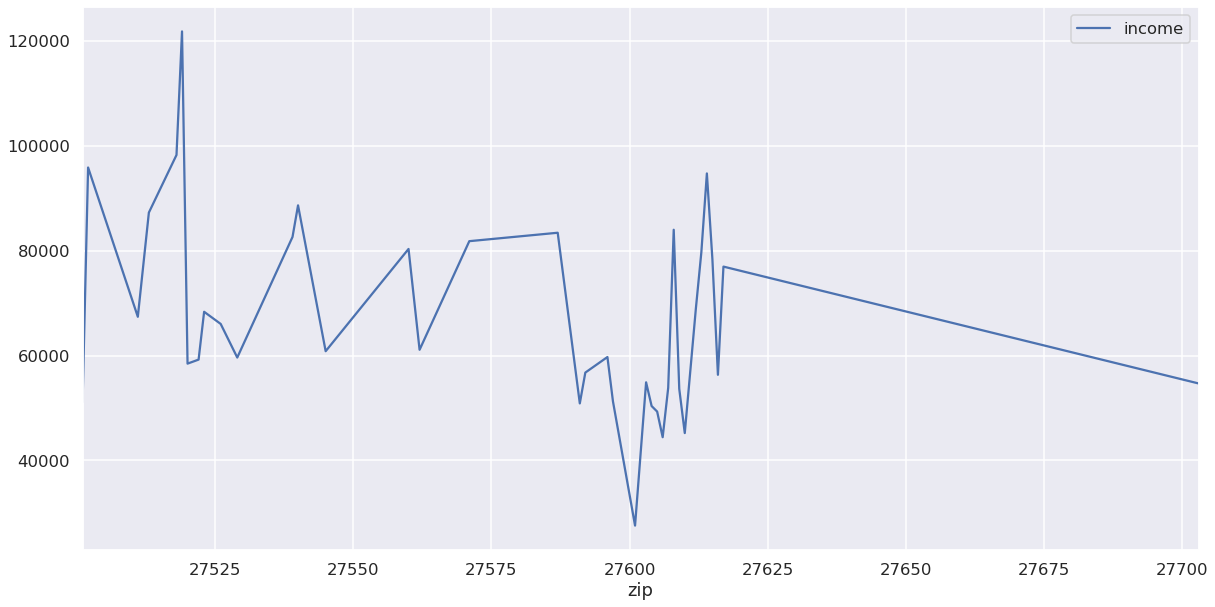

In [265]:
df_zipcodes = df_zipcodes.groupby("zip").mean()
df_zipcodes.plot(y='income',grid=True, figsize=(20,10))

So the above graphs don't show a crazy pattern. Let's continue into the next visualization.

Here I totaled the number of non-critical/critical violation points per zip code. 
The plot with the blue is for non-critical violations, whereas the one with the red is for critical violations.

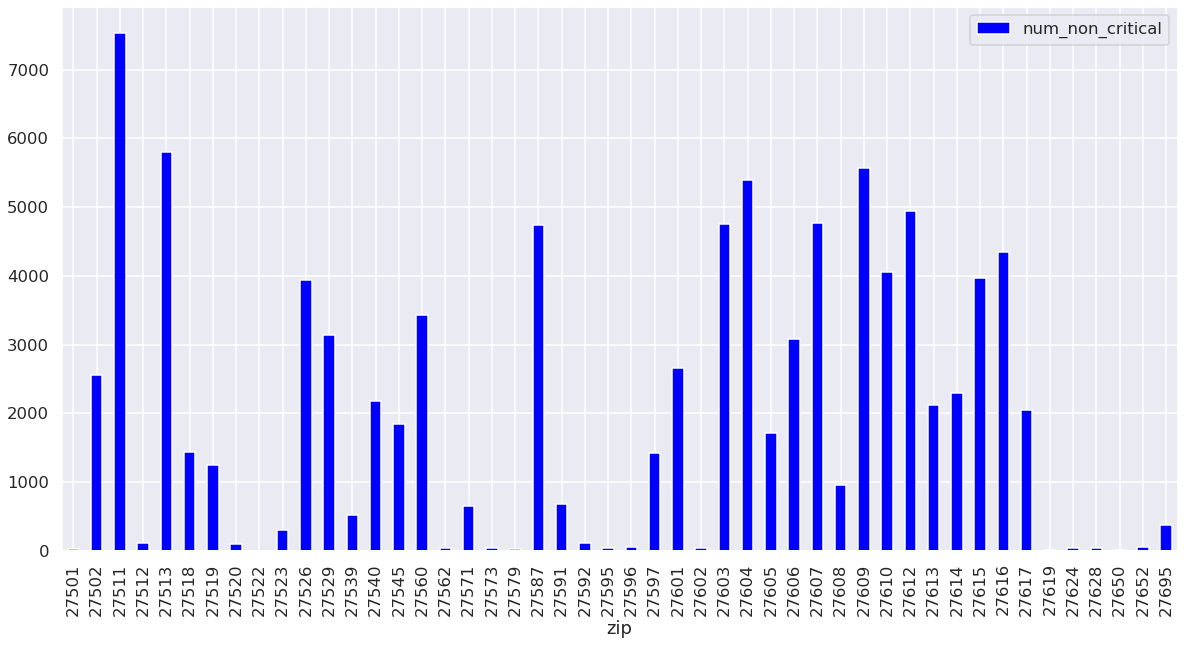

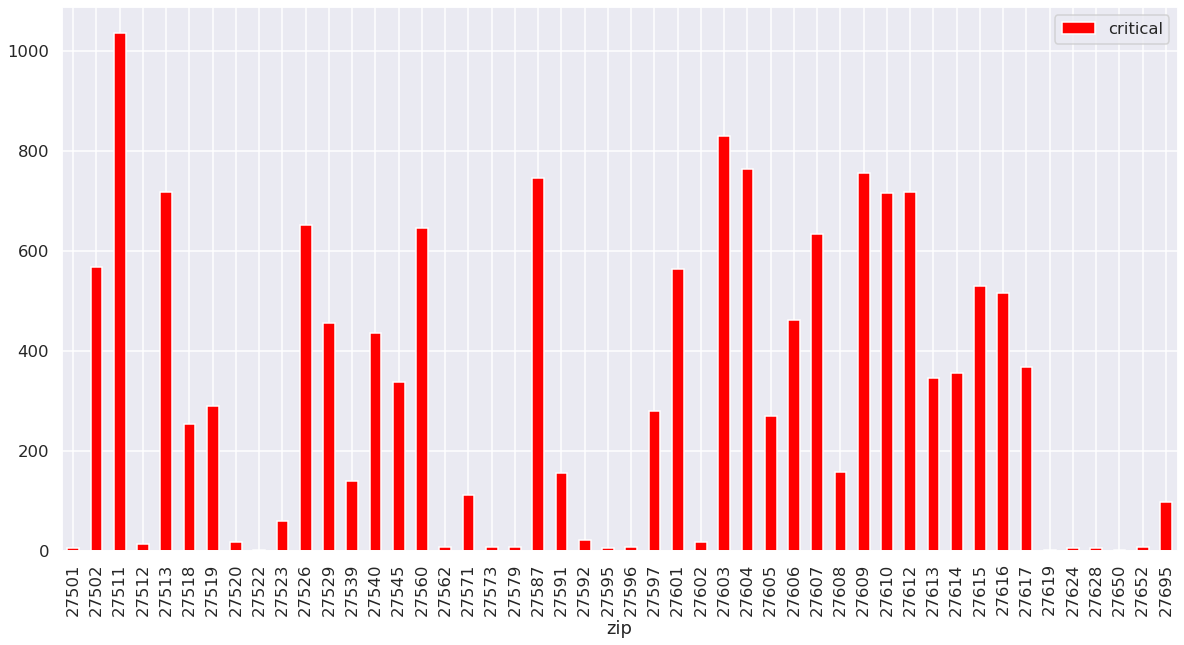

In [336]:
df_inspections = df_inspections.groupby("zip").sum()
df_inspections.plot(kind = 'bar', y='num_non_critical',grid=True, figsize=(20,10), color='blue')

df_inspections.plot(kind = 'bar', y='critical',grid=True, figsize=(20,10), color='red')


Here I plotted the incomes of the zip codes, to see if there was any patterns related to income and critical violations (red chart above).

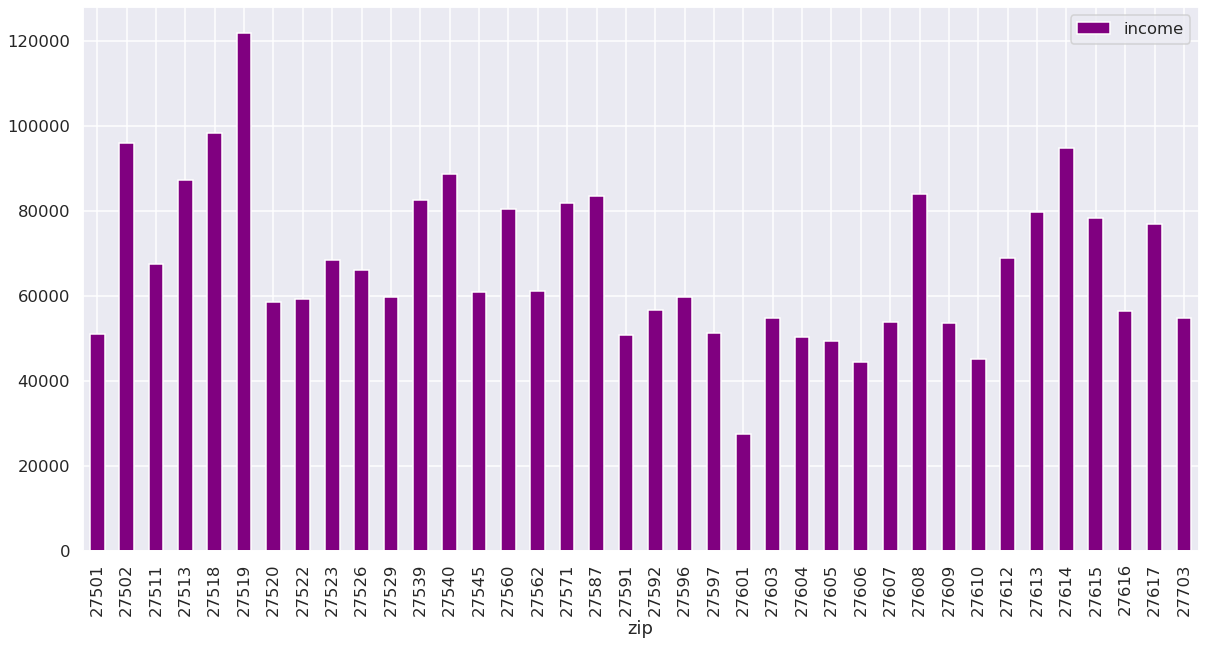

In [335]:
df_zipcodes.plot(kind = 'bar', y='income',grid=True, figsize=(20,10), color='purple')


So the chart above shows that places with lower incomes have the most restaurants. Now I will plot the diversity of non-whites in a community. 

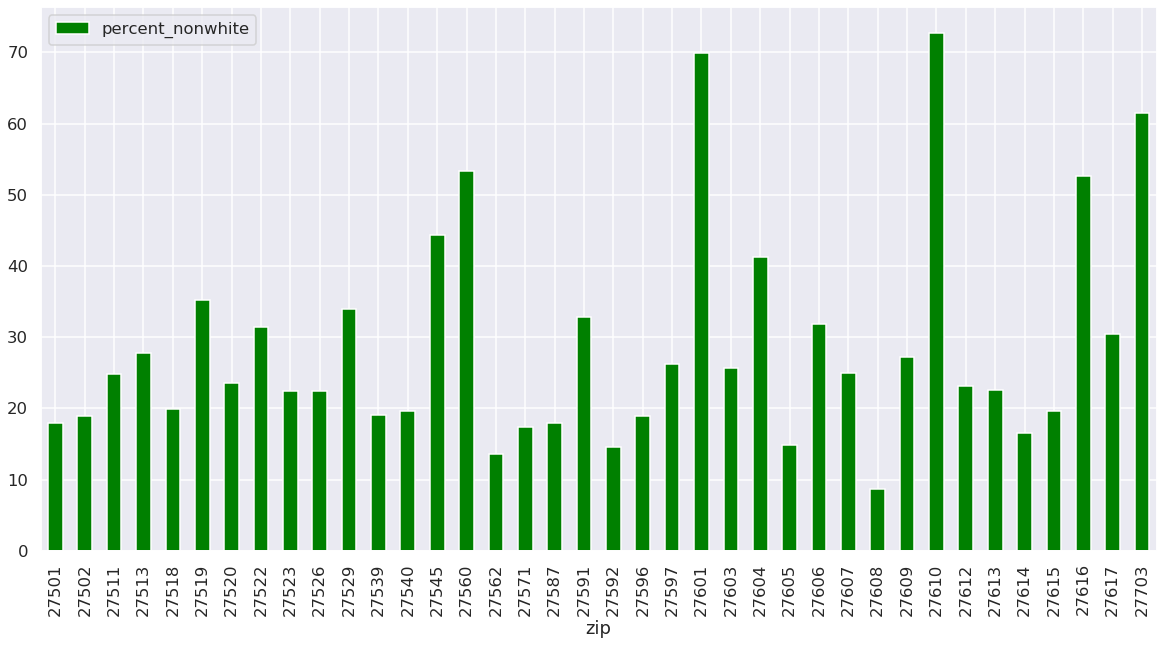

In [341]:
df_zipcodes.plot(kind = 'bar', y='percent_nonwhite',grid=True, figsize=(20,10), color='green')

Looking at these graphs, we have outliers such as zip code 27608, the population that has the most white people and the least amount of critical/noncritical violations. 
So maybe then we could assume that there was a bias towards white communities, but the yelp ratings are proportional to the inspectors critical notes. 
What I mean by that is that places with higher yelp ratings have less critical violations. And places with less restaurants also have less critical points. So nothing here in the data points to a correlation between racial bias and inspection points. There is a pretty equal distribution between diverse communities and whiter communities.
So it results that the data analyzed can't prove that there is racial bias by health inspectors. 

# Ethics & Privacy

All the data was public so there was no problem with that. The only problem I can see is that I did classify the restaurants based on food type, which is very vague in terms of who actually owns and operates the locations. 
What I mean by that is that not only because a restaurant sells 'american' food means that it's a white owned business. Meaning, I should've included a dataset of owners ethnic identities and used those opposed to the type of food sold. 

Also, I didn't correctly quantify the density of the populations, that could be problematic when it came to sums of violations. I needed to standardize that instead of keeping it equal regardless of population count.

# Conclusion & Discussion

So, in conclusion the data doesn't support a correlation between racial bias in the health inspections. In a future study I should include water supply information, and maybe even do a machine learning type of analysis based on what the comments of the yelp reviews actually said. I also would hope to do more detailed work, which time and circumstance didn't allow for me to do. 

My question was fine, as I truly do believe with further studies there could be a link between racial bias and health inspection scores. Instead, though, I could try to focus on factors that could lead to worse scores for more ethnic owned stores. Those could be such things as environmental factors, location of business (near a freeway - air pollution), the water supply, the food suppliers etc. 

A limitation was that there was a lot politically going on these past two weeks that I was involved in, there was no way I could sleep at night with a good conscience knowing I didn't protest and use my White body as a shield to protest Black lives and amplify their voices. So I was phsyically and mentally exhausted from that. On top of that, this Monday I had to go to the ER in the middle of the night because my blood pressure dropped dangerously low (hypotension), causing dizziness and confusion, so I couldn't put my best mental effort in this week, unfortunately, and I know my project suffered because of this. 

Regardless of my situation, a downfall was that I'm not familiar with North Carolina and maybe next time I could use datasets from my own community, as it would make it easier to find relative datasets as I'm more familiar to the hardships there are in more urban neighborhoods in San Diego. 
I would really like to investigate water supplies, and fluoride that is in tap water. That's not on topic with the health inspection thing, but that's something I'd like to do. 